# Assignment 2 Statistical Learning and Prediction

1. Analyze the dataset "session_7:dataset.xlsx" to estimate property prices as a regression problem where the target variable is "inm_price". 
    - Perform a thourough EDA and explain the findings 
    - Use algorithms seen so far in class with Scikit learn or other frameworks for the prediction and measure it's performance.

2. Analyze data and redefine the problem to create a classification one.
    Use the following algorithms and analyze the results:
    - Perceptron Learning Algorithm
    - Logistic Regression
    - Generative Model (LDA,QDA)
    - KNN

3. Extra - use other methods you may know and compare results with the previous ones.

## EDA

In [204]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.linear_model import LinearRegression, Perceptron, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import f_oneway

# Statistical Analysis
from scipy.stats import skew

# Pandas options for display
pd.options.display.max_columns = None



In [205]:
# Load the dataset
df = pd.read_excel('session_7_dataset.xlsx', index_col=0)

# Step 1: Initial Descriptive Statistics
def perform_eda(df):
    print("First few rows of the dfset:")
    print(df.head())
    print("\nDftype of each column:")
    print(df.dtypes)
    print("\nPerecentage of missing values in each column:")
    print(round(df.isnull().sum()/len(df)*100, 3))
    print("\nDescriptive statistics of the dfset:")
    print(df.describe())

perform_eda(df)

First few rows of the dfset:
   inm_floor  inm_size  inm_price  inm_longitude  inm_latitude   inm_barrio  \
0        3.0     141.0     990000      -3.656875     40.464347     Canillas   
1        2.0     159.0     940000      -3.703523     40.419427  Universidad   
2        NaN       NaN     549000      -3.669626     40.435362   Guindalera   
3        2.0     232.0     750000      -3.720619     40.424164    Argüelles   
4        4.0     183.0    1550000      -3.705909     40.413214          Sol   

        inm_distrito  his_price  his_quarterly_variation  \
0          Hortaleza       3250                      2.2   
1             Centro       5106                      1.4   
2          Salamanca       4100                      0.6   
3  Moncloa - Aravaca       4773                      0.5   
4             Centro       4739                     -5.5   

   his_annual_variation  his_monthly_variation  \
0                   0.3                    2.1   
1                  -4.3            

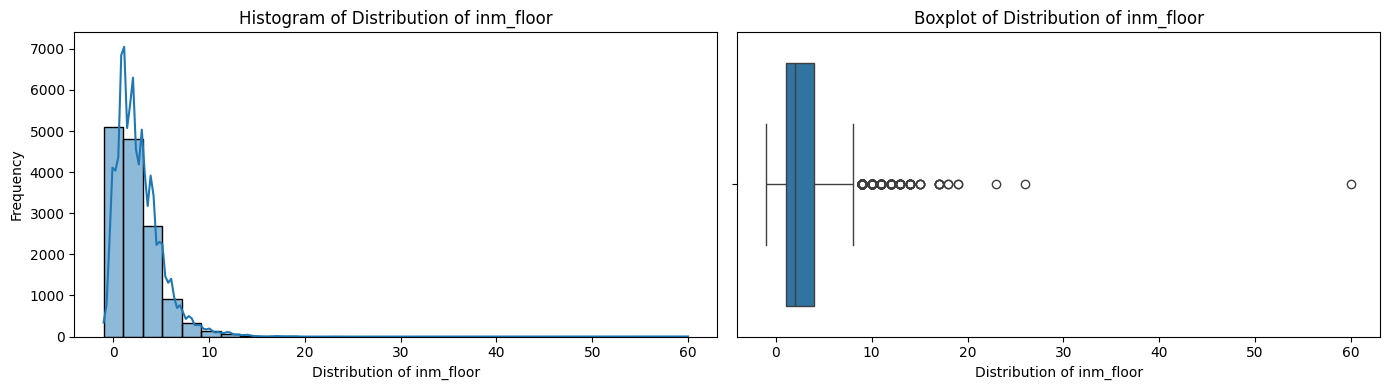

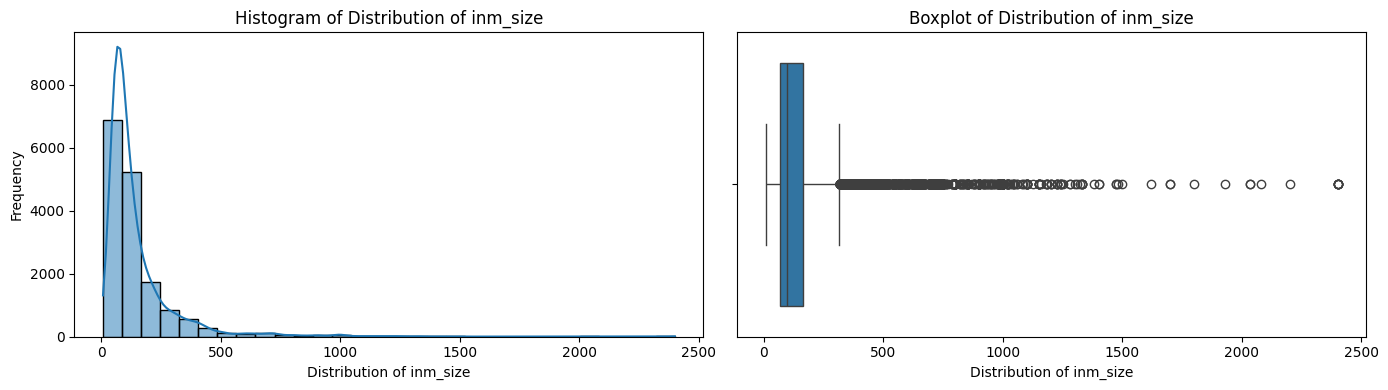

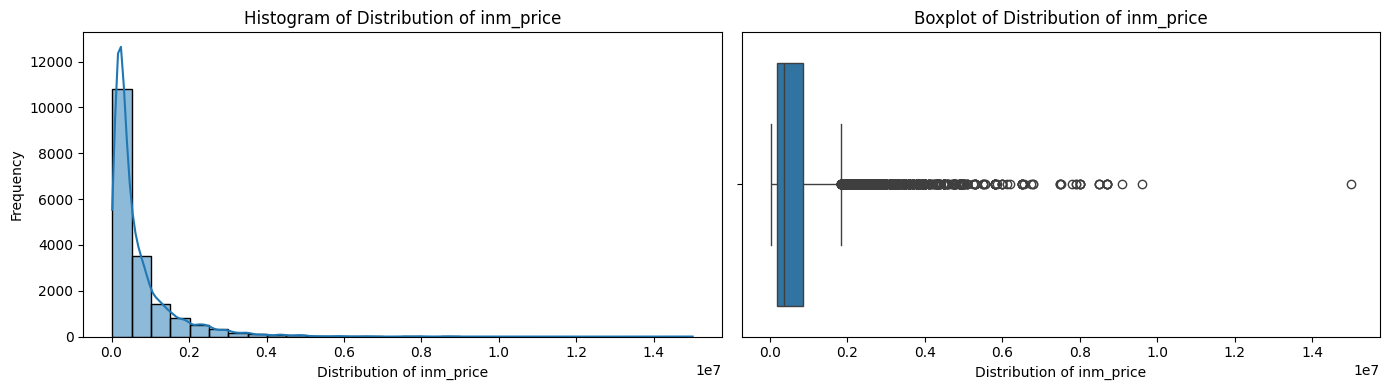

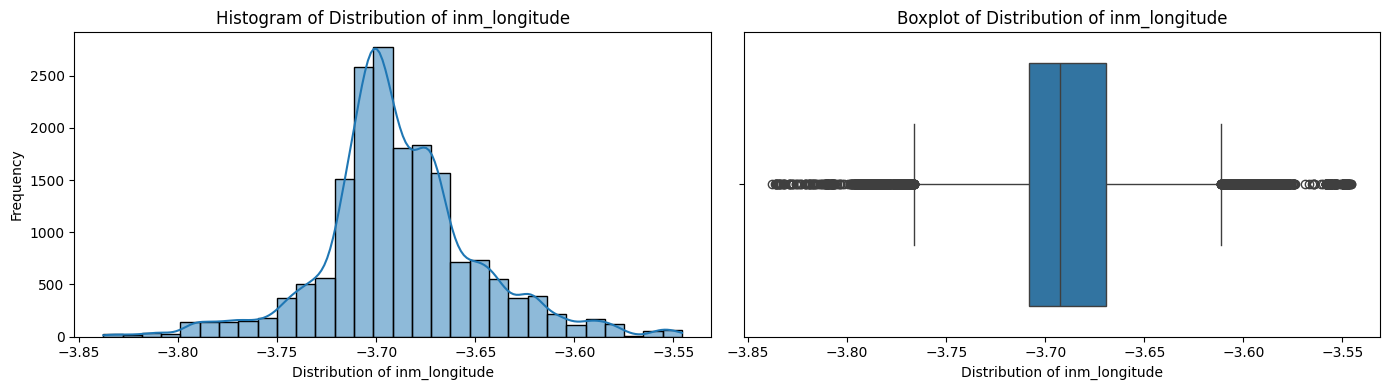

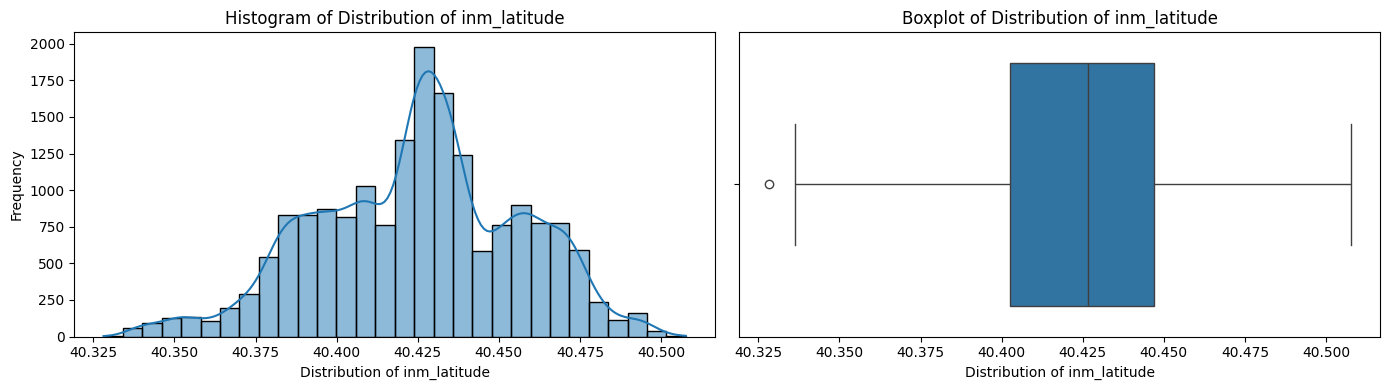

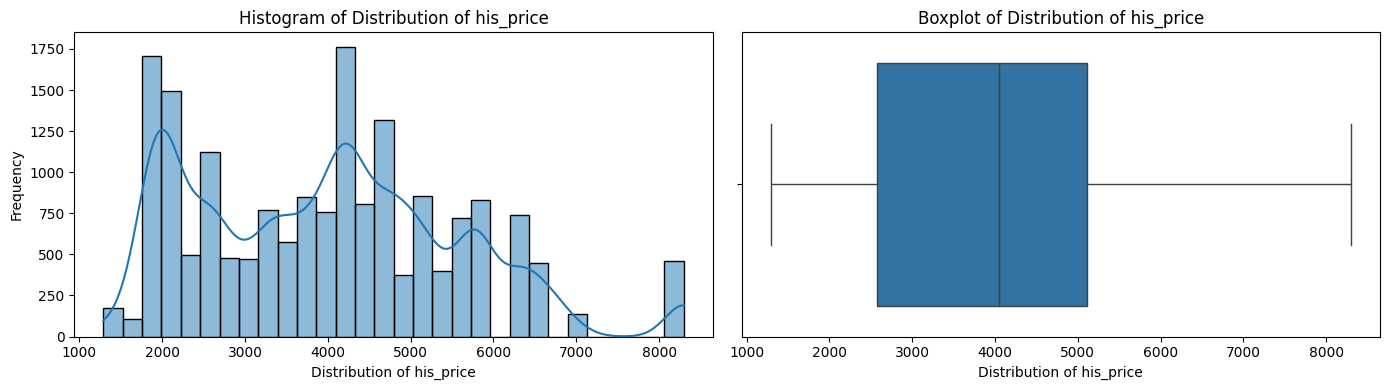

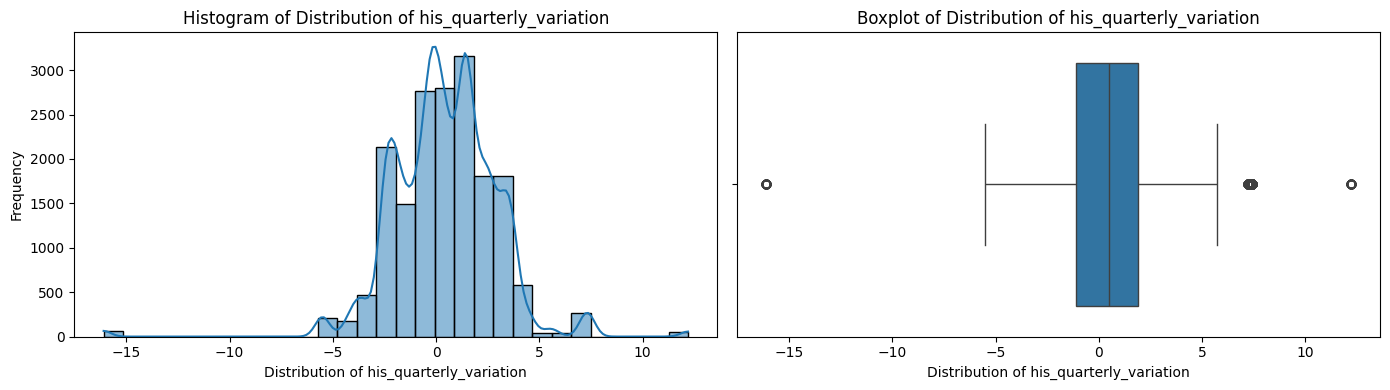

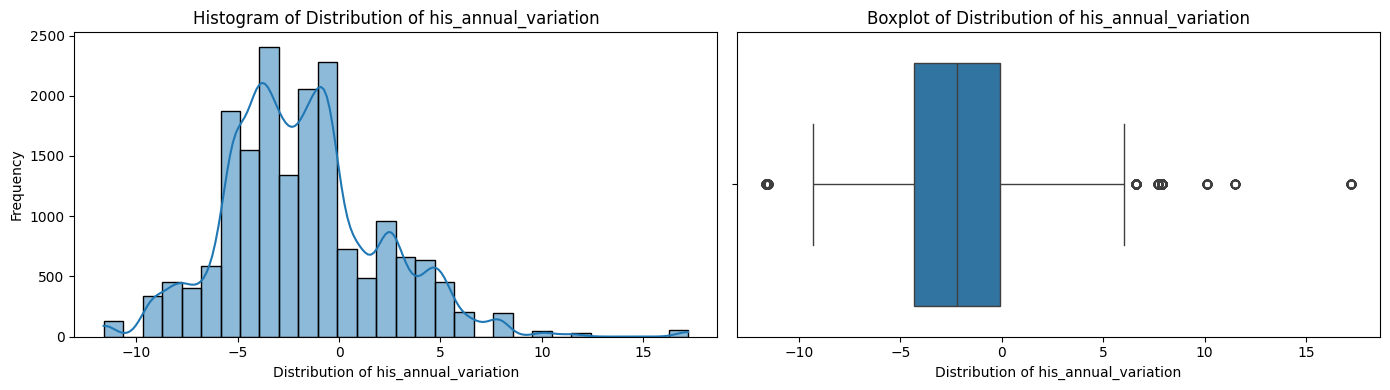

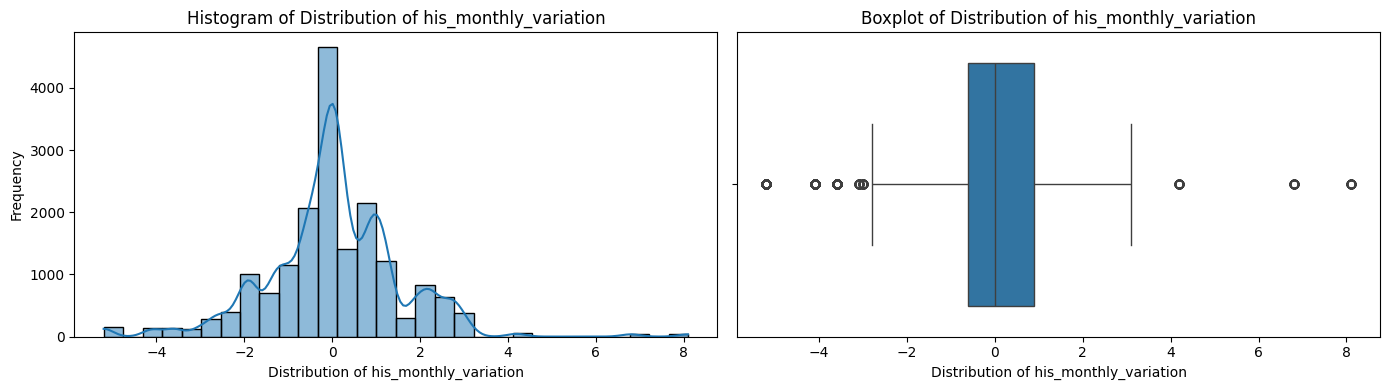

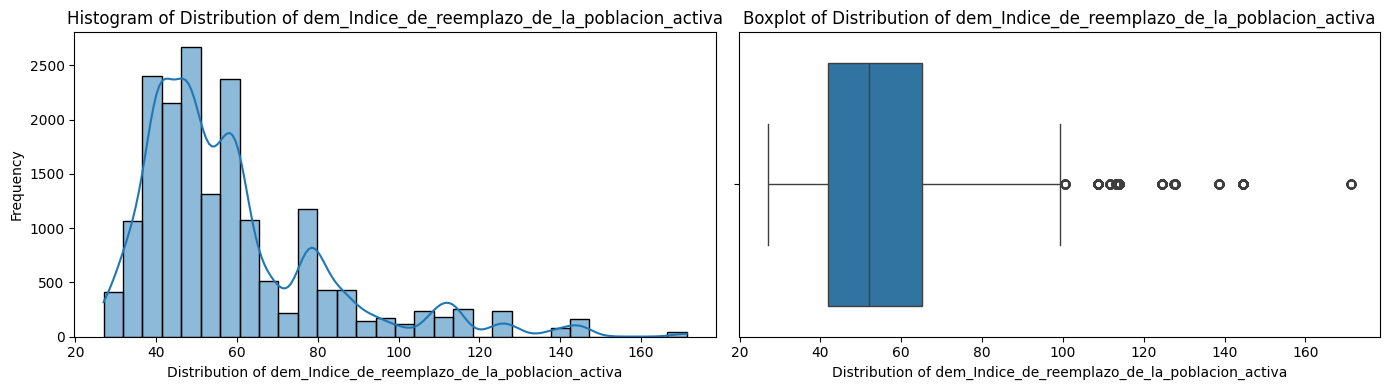

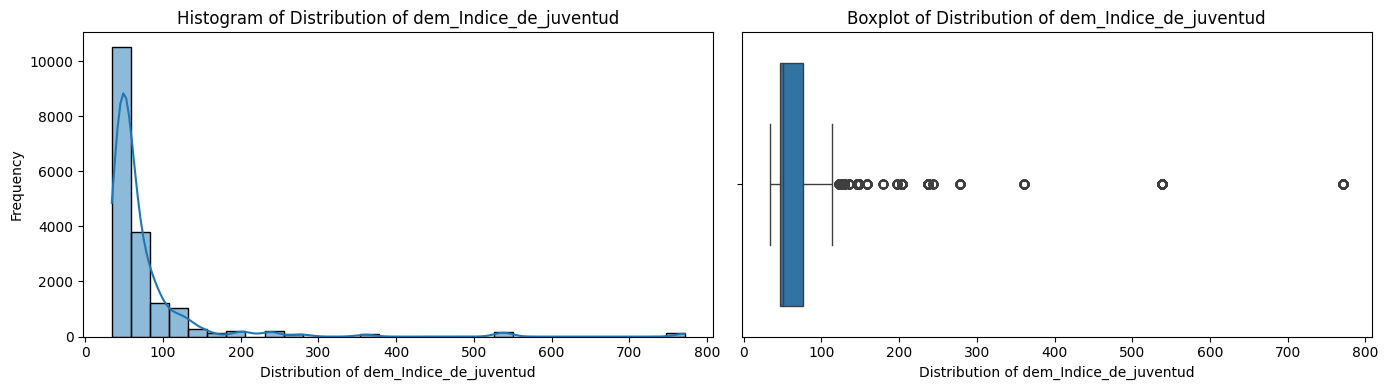

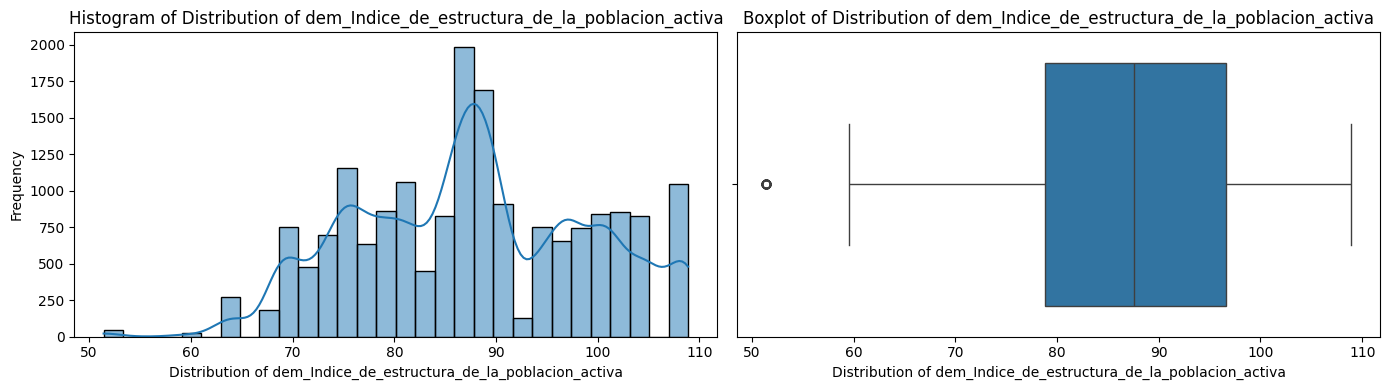

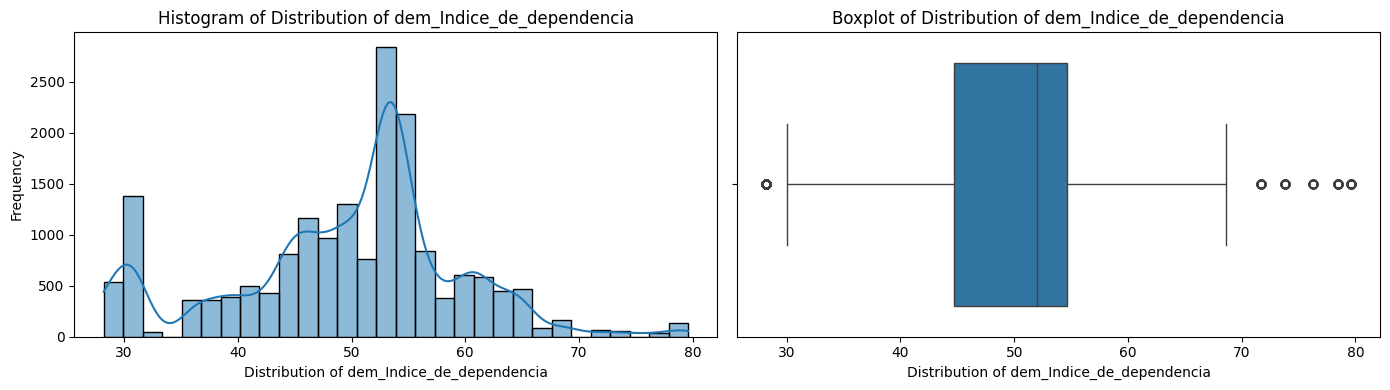

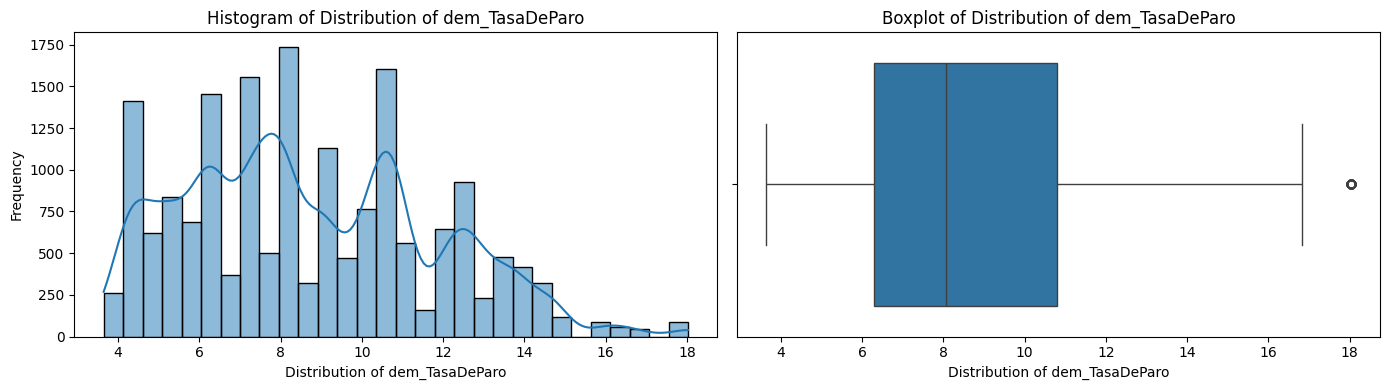

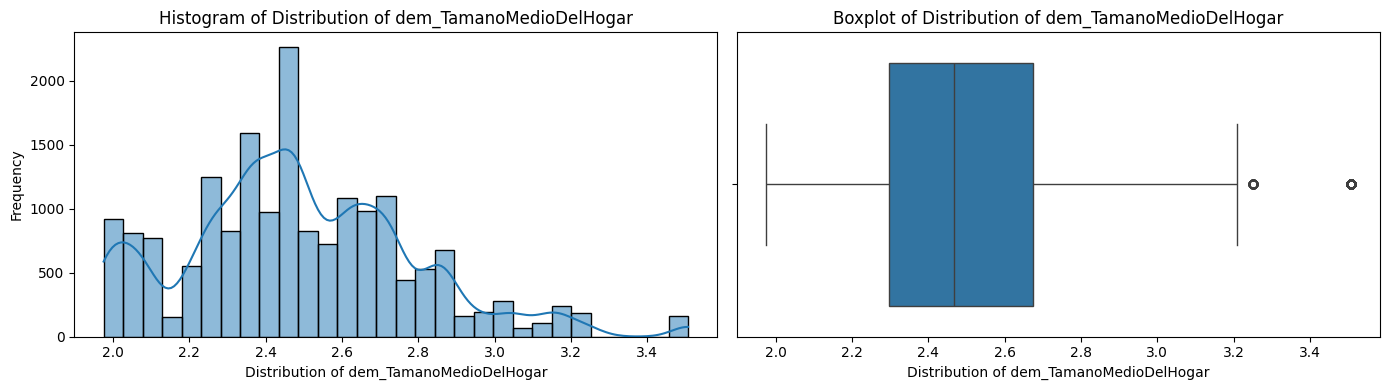

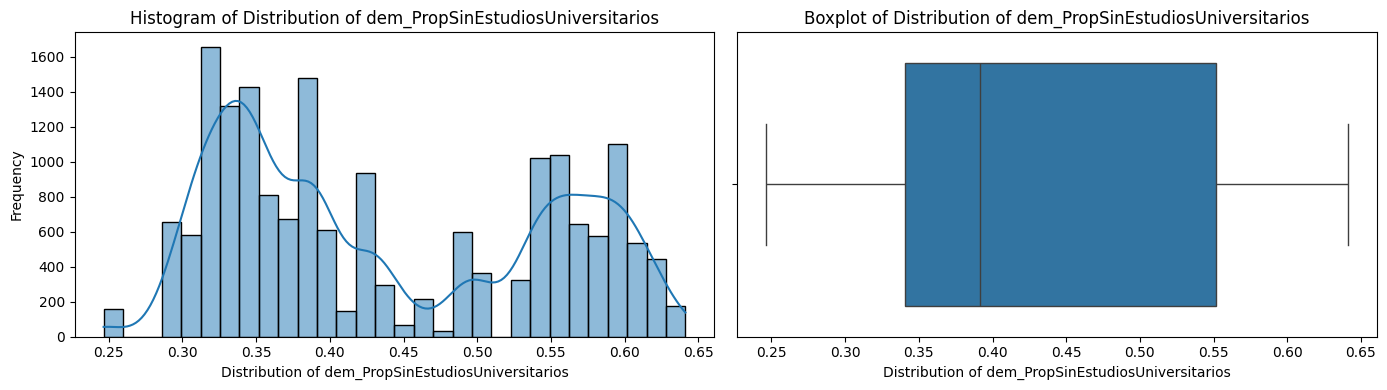

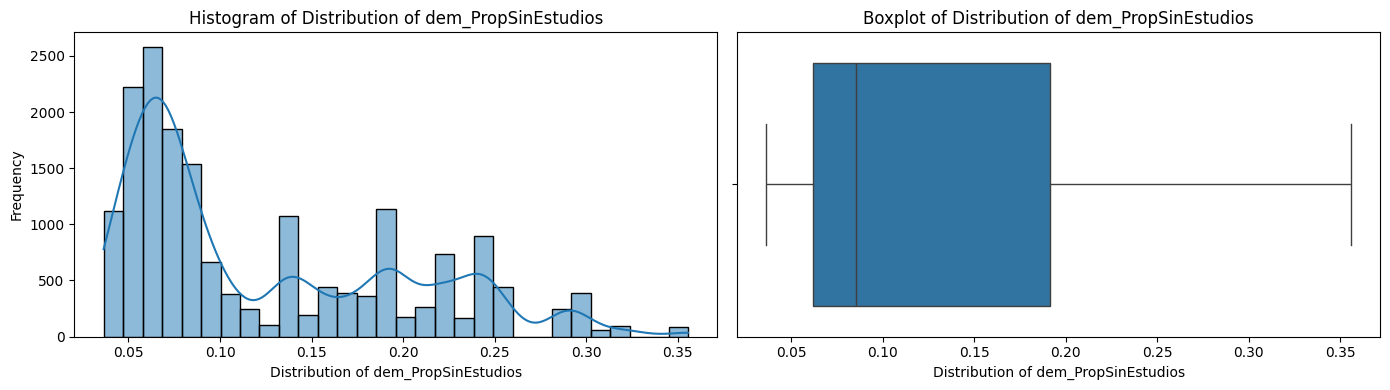

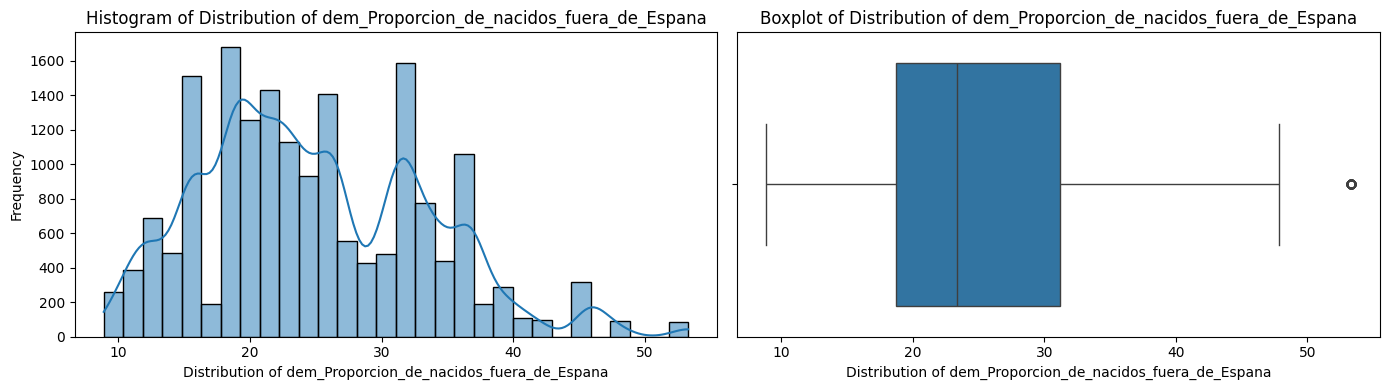

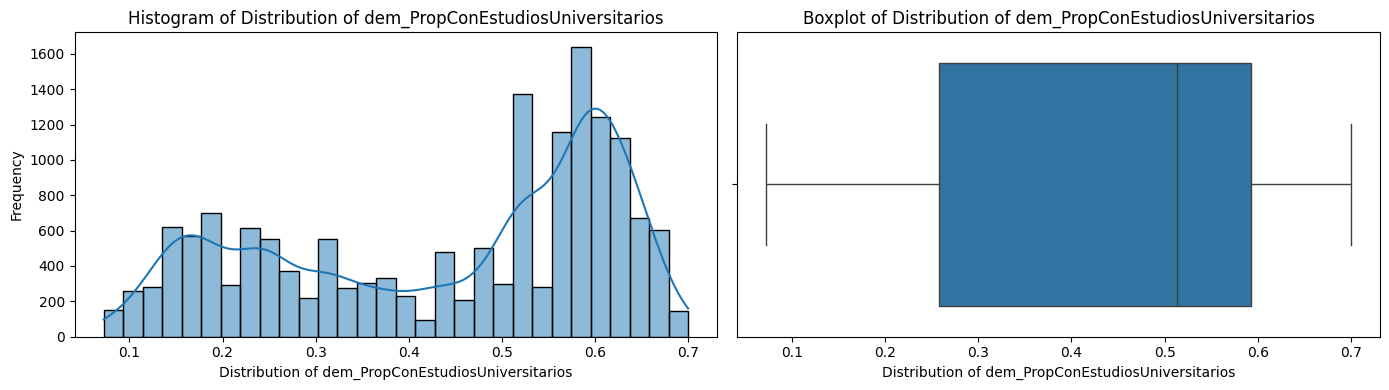

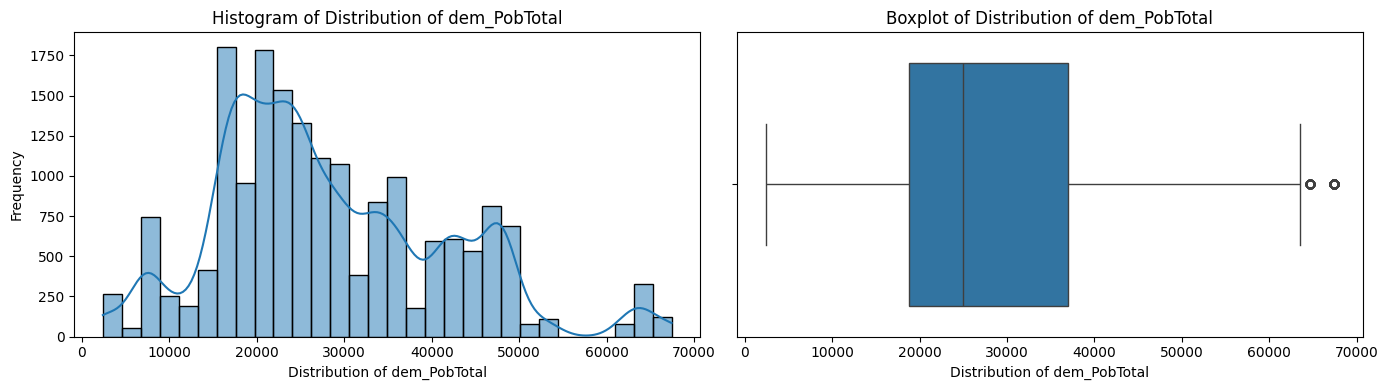

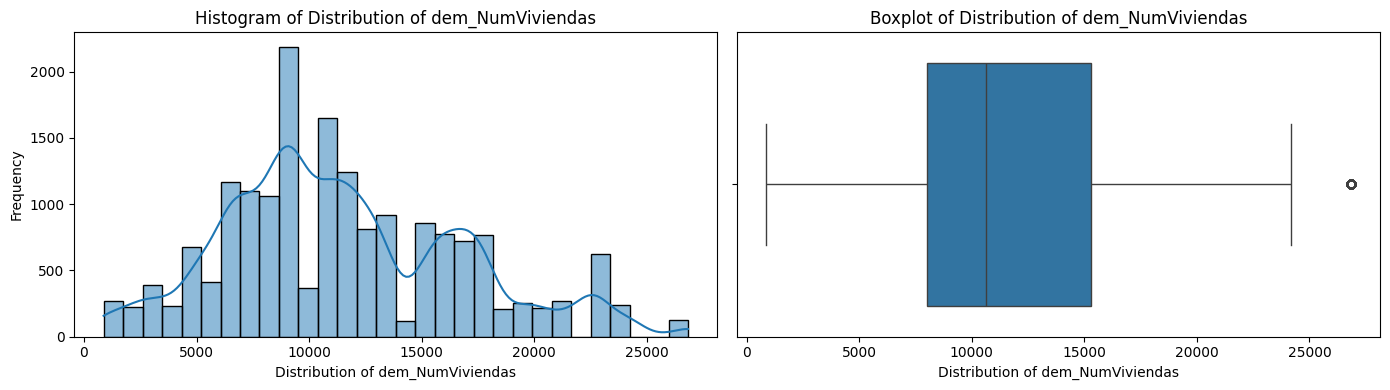

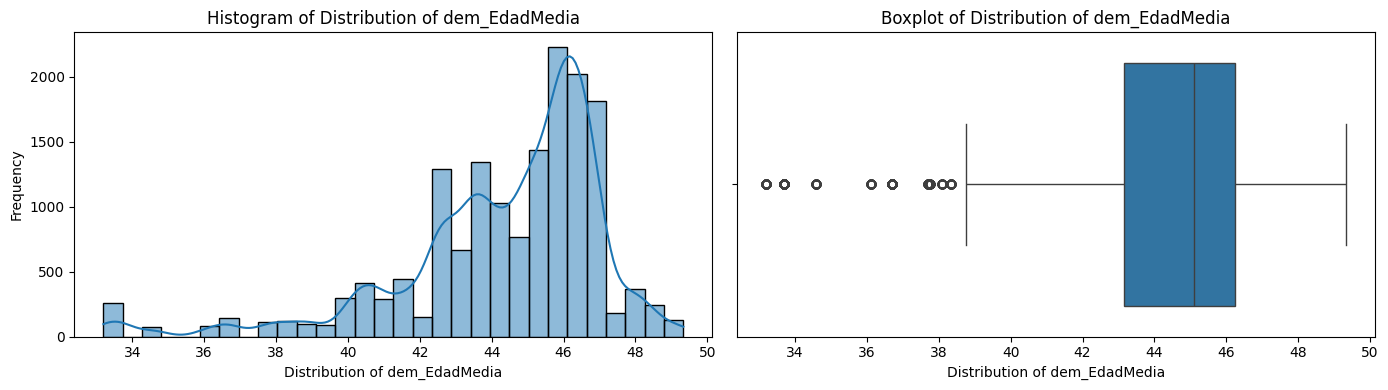

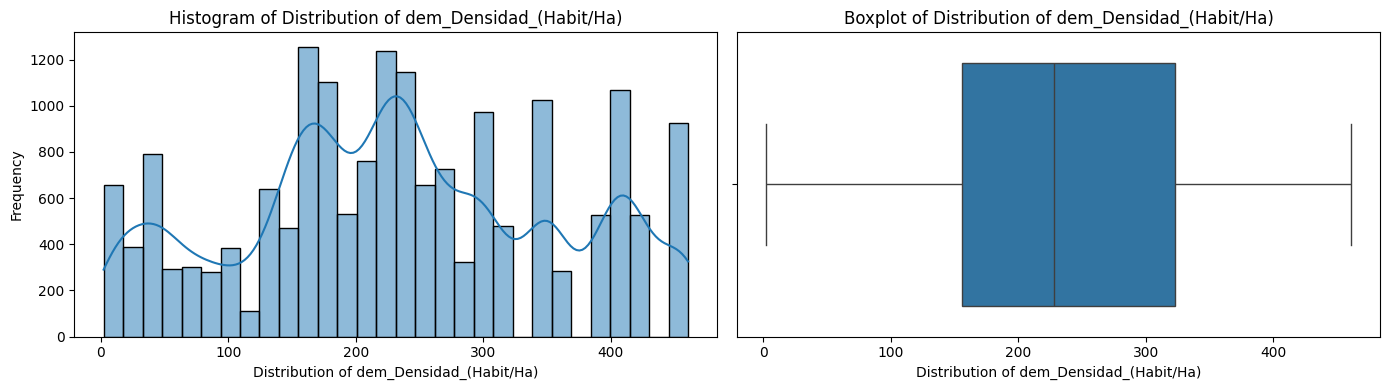

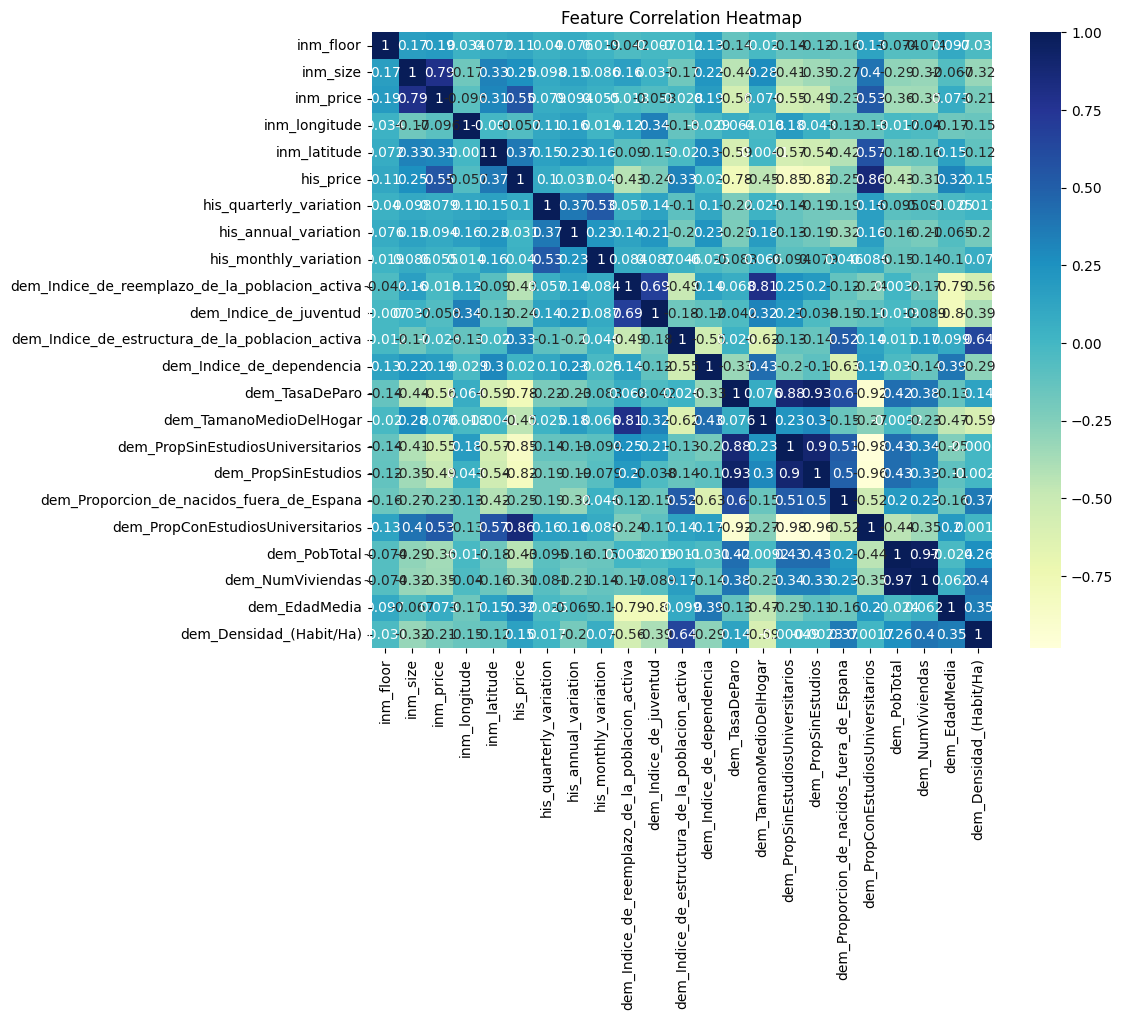

In [206]:
# Function to create histograms and boxplots for numerical features
def plot_distribution(data, column, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))

    # Histogram
    sns.histplot(data[column], bins=30, ax=ax[0], kde=True)
    ax[0].set_title(f'Histogram of {title}')
    ax[0].set_xlabel(title)
    ax[0].set_ylabel('Frequency')

    # Boxplot
    sns.boxplot(x=data[column], ax=ax[1])
    ax[1].set_title(f'Boxplot of {title}')
    ax[1].set_xlabel(title)

    plt.tight_layout()
    plt.show()

# Function to plot correlation heatmap between numerical features
def plot_correlation_heatmap(data):
    # Select only numeric columns for correlation calculation
    numeric_data = data.select_dtypes(include=['number'])  # This filters out non-numeric columns
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_data.corr(), annot=True, cmap='YlGnBu')  # Calculate and plot correlation of numeric columns only
    plt.title('Feature Correlation Heatmap')
    plt.show()

# Plotting distributions for numerical variables
for column in df.columns:
    # Check if the column is numerical
    if df[column].dtype in ['float64', 'int64']:
        plot_title = f'Distribution of {column}'
        plot_distribution(df, column, plot_title)

# Correlation matrix
plot_correlation_heatmap(df)


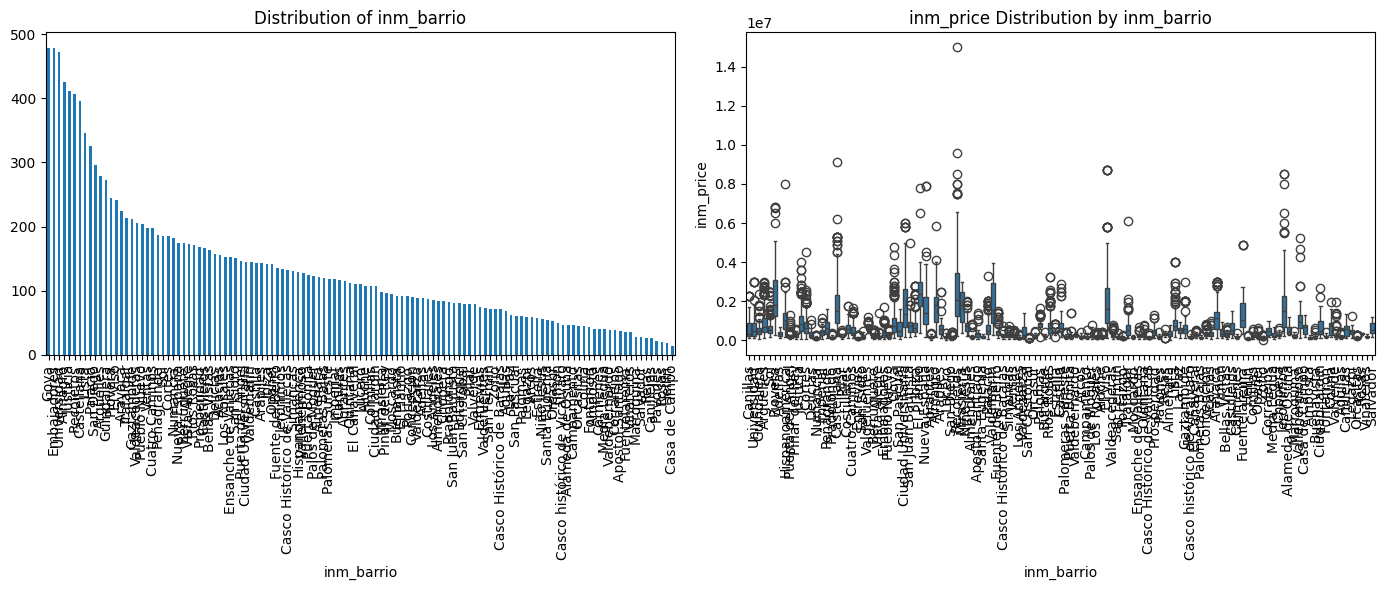

ANOVA test for inm_barrio: F-value = 132.6050548975655, p-value = 0.0


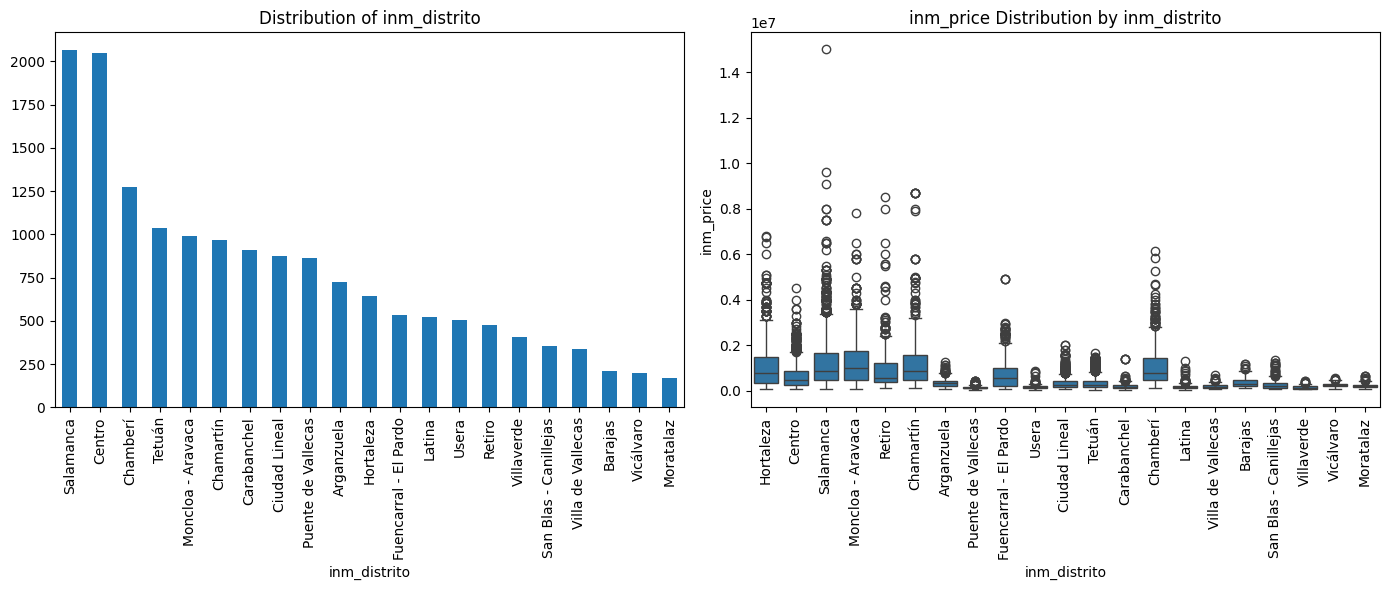

ANOVA test for inm_distrito: F-value = 287.87180676722835, p-value = 0.0


In [207]:
# Plot the frequency distribution of a categorical variable.
def plot_distribution(df, column):
    df[column].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=90)

# Plot the distribution of the target variable across categories.
def plot_price_distribution(df, cat_column, target_column):
    sns.boxplot(x=cat_column, y=target_column, data=df)
    plt.title(f'{target_column} Distribution by {cat_column}')
    plt.xticks(rotation=90)

# Perform ANOVA and return the F and p-values
def perform_anova(df, cat_column, target_column):
    groups = [group[target_column].dropna() for name, group in df.groupby(cat_column)]
    f_val, p_val = f_oneway(*groups)
    return f_val, p_val

# Define categorical and target columns
categorical_columns = ['inm_barrio', 'inm_distrito']
target_column = 'inm_price'

# Plot distribution and price distribution for each categorical variable
for cat_col in categorical_columns:
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plot_distribution(df, cat_col)
    
    plt.subplot(1, 2, 2)
    plot_price_distribution(df, cat_col, target_column)
    
    plt.tight_layout()
    plt.show()

    # Perform ANOVA
    f_val, p_val = perform_anova(df, cat_col, target_column)
    print(f"ANOVA test for {cat_col}: F-value = {f_val}, p-value = {p_val}")


/var/folders/p9/6x7xnkc9575f45rpxl6ygb0m0000gn/T/ipykernel_60797/2118601698.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


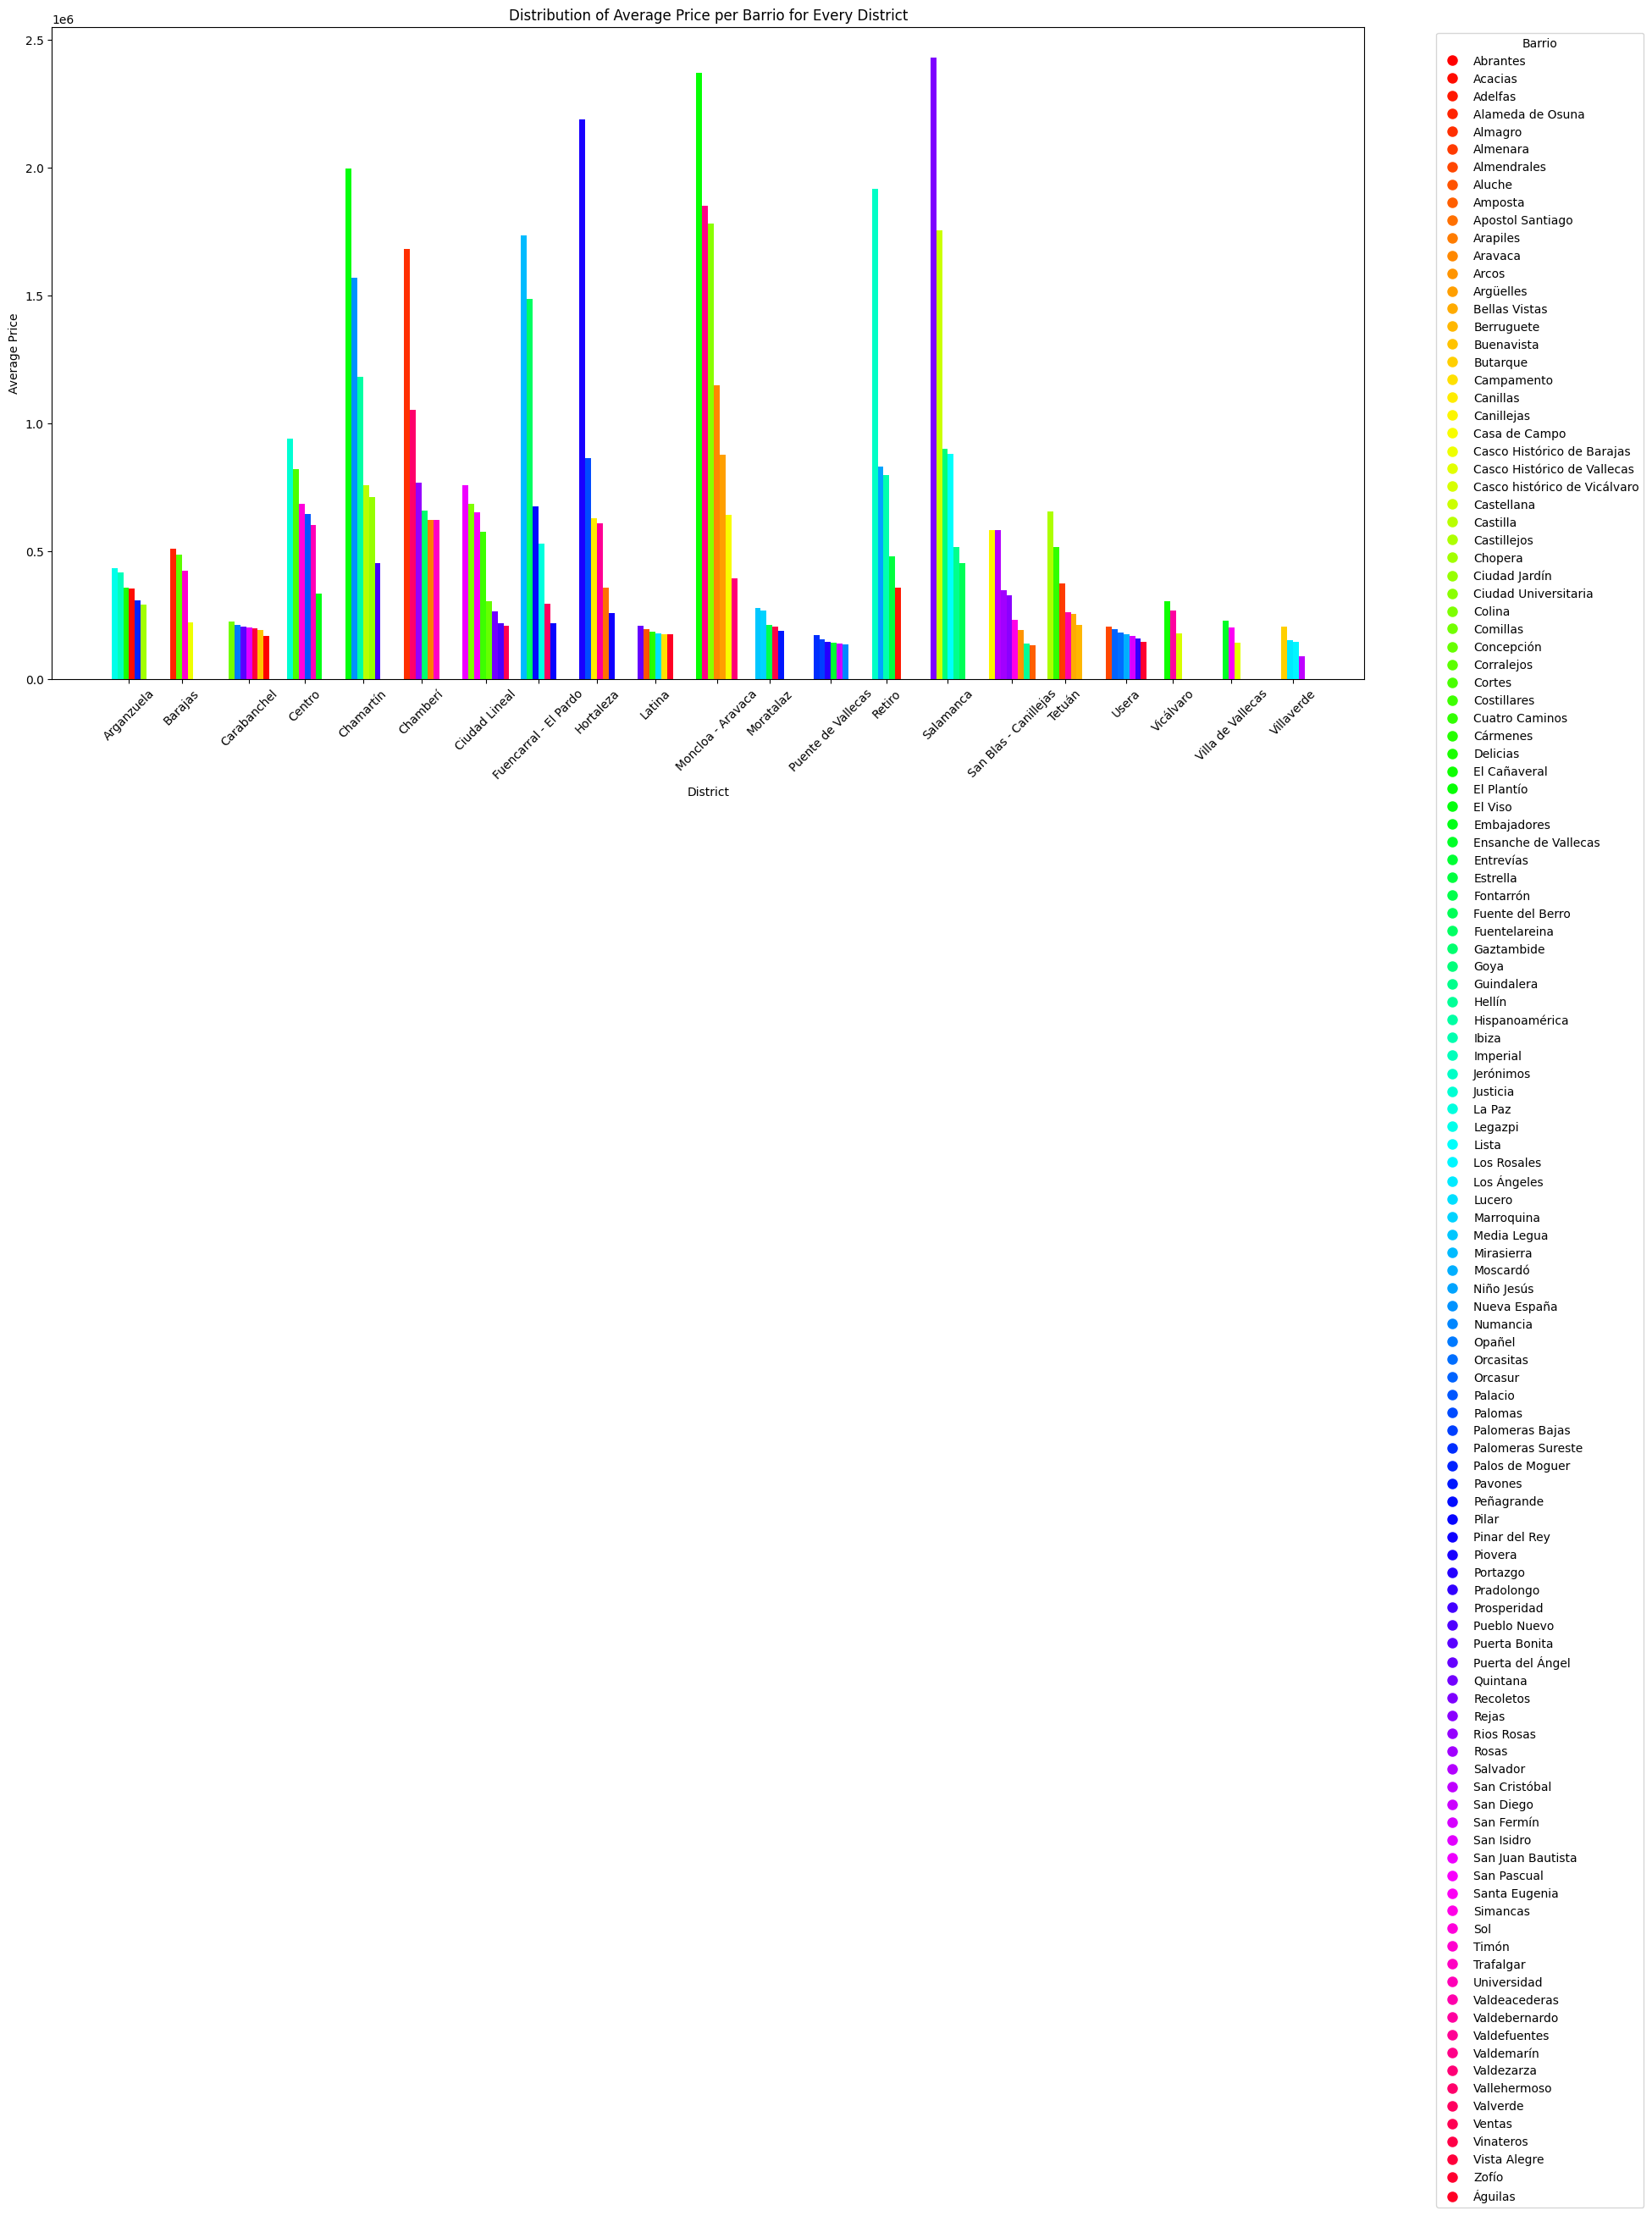

In [208]:
# Calculate the average price for each barrio within each district.
def calculate_average_price(data):
    avg_price_per_barrio = data.groupby(['inm_distrito', 'inm_barrio'])['inm_price'].mean().reset_index()
    avg_price_per_barrio.sort_values(by=['inm_distrito', 'inm_price'], ascending=[True, False], inplace=True)
    return avg_price_per_barrio

# Generate a color mapping for each barrio.
def generate_color_mapping(data):
    barrios = sorted(data['inm_barrio'].unique())
    color_map = plt.get_cmap('hsv')
    barrio_colors = {barrio: color_map(i / len(barrios)) for i, barrio in enumerate(barrios)}
    return barrio_colors

# Plot the average price for each barrio within each district.
def plot_average_price(avg_price_per_barrio, barrio_colors):
    plt.figure(figsize=(20, 10))
    bar_width = 0.1

    districts = sorted(avg_price_per_barrio['inm_distrito'].unique())
    district_offsets = {district: 0 for district in districts}
    
    for _, row in avg_price_per_barrio.iterrows():
        district = row['inm_distrito']
        barrio = row['inm_barrio']
        price = row['inm_price']
        position = districts.index(district) + district_offsets[district] * bar_width
        plt.bar(position, price, width=bar_width, color=barrio_colors[barrio], align='center')
        district_offsets[district] += 1

    plt.xticks([districts.index(d) + (district_offsets[d] * bar_width) / 2 - bar_width / 2 for d in districts], districts, rotation=45)
    plt.xlabel('District')
    plt.ylabel('Average Price')
    plt.title('Distribution of Average Price per Barrio for Every District')
    create_legend(barrio_colors)

    plt.tight_layout()
    plt.show()

# Create a legend for the barrio colors.
def create_legend(barrio_colors):
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=barrio,
                                   markerfacecolor=barrio_colors[barrio], markersize=10) for barrio in barrio_colors]
    plt.legend(handles=legend_elements, title='Barrio', bbox_to_anchor=(1.05, 1), loc='upper left')

# Executing the functions
avg_price_per_barrio = calculate_average_price(df)
barrio_colors = generate_color_mapping(avg_price_per_barrio)
plot_average_price(avg_price_per_barrio, barrio_colors)

## Statistical Summary Insights

#### Numerical Columns
- **Floor (inm_floor)**: Ranges from -1 to 60, with a median of 2.
- **Size (inm_size)**: Ranges from 8 to 2400 (units), with a median of 98.
- **Price (inm_price)**: Ranges from 16,000 to 15,000,000, with a median of 370,000.
- **Geographical Coordinates**: Vary within specific ranges, indicating properties are spread across different locations.
- **Historical Prices and Variations**: Show a range of values with both positive and negative variations.
- **Demographics**: Includes indices, rates, and proportions with a wide range of values. Multicolinearity between 'dem_PropSinEstudiosUniversitarios' and 'dem_PropConEstudiosUniversitarios'.

#### Categorical Columns
- **Neighborhood (inm_barrio)**: The 122 neighborhoods impact property prices significantly (ANOVA: F-value = 132.605, p-value ≈ 0), with 'Unknown' values indicating the need for data imputation.
- **District (inm_distrito)**: 22 districts, notably 'Salamanca', show marked influence on prices (ANOVA: F-value = 287.871, p-value ≈ 0), underscoring location's role in property valuation.

## Feature Engineering and Linear Regression

RMSE: 0.25241336284321575
R²: 0.9220466104485142


/Users/bestricemossberg/Projects/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


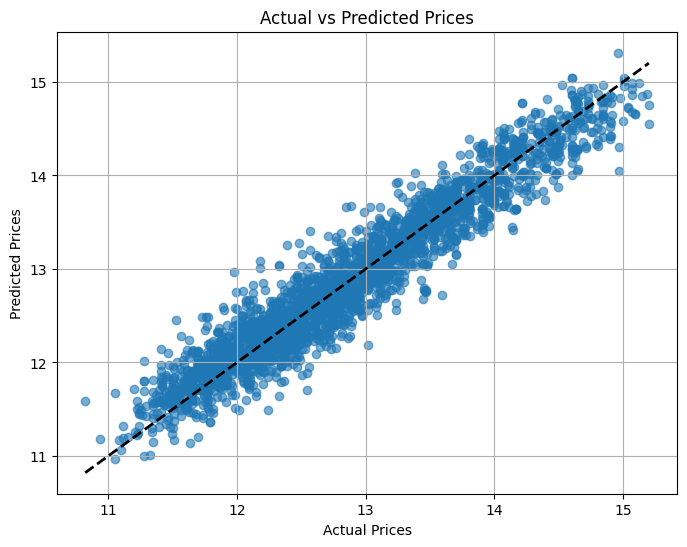

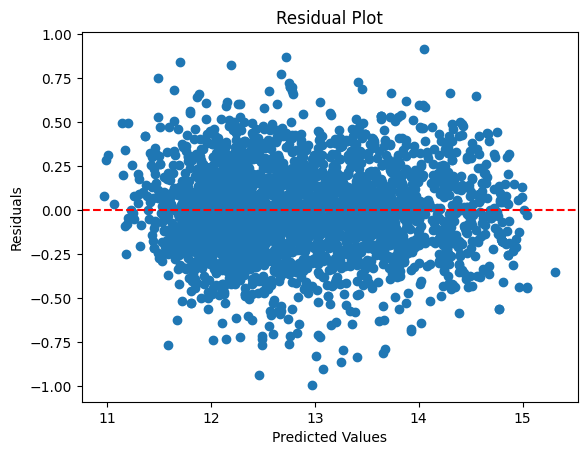

In [209]:
# Feature Engineering - Log transformation
for feature in ['inm_price', 'inm_size', 'his_price']:
    df[f'log_{feature}'] = np.log1p(df[feature])


# Defining thresholds and filtering out outliers
thresholds = {col: df[col].quantile(0.99) for col in ['log_inm_price', 'log_inm_size', 'log_his_price', 'dem_TasaDeParo', 'dem_PropConEstudiosUniversitarios', 'dem_PropSinEstudios', 'dem_PobTotal']}
criteria = np.all([df[col] < thresholds[col] for col in thresholds], axis=0)
df_filtered = df[criteria]


# Demographic columns and categorical features
numeric_features = ['log_inm_size', 'log_his_price', 'inm_longitude', 'inm_latitude', 'dem_TasaDeParo', 'dem_PropConEstudiosUniversitarios', 'dem_PropSinEstudios', 'dem_PobTotal']
categorical_features = ['inm_barrio', 'inm_distrito']

# Features for the model
features = numeric_features + categorical_features
X = df_filtered[features]
y = df_filtered['log_inm_price']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Creating the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# Plotting the actual vs predicted prices
def plot_actual_vs_predicted(y_test, y_pred, title='Actual vs Predicted Prices', xlabel='Actual Prices', ylabel='Predicted Prices'):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Adds a reference line
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Plotting the residuals
def plot_residuals(actual, predicted):
    """Plot residuals of the regression model."""
    residuals = actual - predicted
    plt.scatter(predicted, residuals)
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

plot_actual_vs_predicted(y_test, y_pred)
plot_residuals(y_test, y_pred)

## Regression to Classification Problem

Classifying property price categories of High, Medium and Low

In [210]:
# Defining price categories based on the distribution of 'inm_price'
price_bins = [0, np.percentile(df['inm_price'], 33), np.percentile(df['inm_price'], 66), np.inf]
price_labels = ['Low', 'Medium', 'High']
df['price_category'] = pd.cut(df['inm_price'], bins=price_bins, labels=price_labels, include_lowest=True)

# Dropping the original 'inm_price' as it's no longer needed for classification
df_clean = df.drop(columns=['inm_price'])

# Checking the distribution of the new categorical target variable
price_category_distribution = df_clean['price_category'].value_counts()
price_category_distribution


price_category
High      6072
Low       5957
Medium    5828
Name: count, dtype: int64

In [211]:
# Separating features and the target variable
X = df_clean.drop('price_category', axis=1)
y = df_clean['price_category']

# Identifying numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

# Creating transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Preprocessing the data
X_preprocessed = preprocessor.fit_transform(X)

# Splitting data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape



((14285, 167), (3572, 167), (14285,), (3572,))

In [212]:
# Initializing models
models = {
    "Perceptron": Perceptron(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Training and evaluating each model
for name, model in models.items():
    # Preparing the data (converting to dense format if necessary)
    X_train_mod = X_train.toarray() if 'Discriminant Analysis' in name else X_train
    X_test_mod = X_test.toarray() if 'Discriminant Analysis' in name else X_test

    # Training the model
    model.fit(X_train_mod, y_train)
    
    # Making predictions on the test set
    y_pred = model.predict(X_test_mod)
    
    # Displaying the evaluation metrics
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 50)

Model: Perceptron
              precision    recall  f1-score   support

        High       0.97      0.98      0.97      1230
         Low       0.91      0.99      0.95      1184
      Medium       0.97      0.86      0.91      1158

    accuracy                           0.95      3572
   macro avg       0.95      0.94      0.94      3572
weighted avg       0.95      0.95      0.95      3572

Confusion Matrix:
[[1207    0   23]
 [   0 1171   13]
 [  40  118 1000]]
--------------------------------------------------
Model: Logistic Regression
              precision    recall  f1-score   support

        High       0.99      0.99      0.99      1230
         Low       0.99      0.99      0.99      1184
      Medium       0.98      0.98      0.98      1158

    accuracy                           0.99      3572
   macro avg       0.99      0.99      0.99      3572
weighted avg       0.99      0.99      0.99      3572

Confusion Matrix:
[[1222    0    8]
 [   0 1167   17]
 [  14   11 113

/Users/bestricemossberg/Projects/venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Model: Quadratic Discriminant Analysis
              precision    recall  f1-score   support

        High       0.49      1.00      0.66      1230
         Low       0.75      0.67      0.71      1184
      Medium       0.73      0.01      0.01      1158

    accuracy                           0.57      3572
   macro avg       0.66      0.56      0.46      3572
weighted avg       0.65      0.57      0.46      3572

Confusion Matrix:
[[1228    2    0]
 [ 390  791    3]
 [ 887  263    8]]
--------------------------------------------------
Model: K-Nearest Neighbors
              precision    recall  f1-score   support

        High       0.93      0.93      0.93      1230
         Low       0.91      0.92      0.91      1184
      Medium       0.84      0.84      0.84      1158

    accuracy                           0.90      3572
   macro avg       0.89      0.89      0.89      3572
weighted avg       0.90      0.90      0.90      3572

Confusion Matrix:
[[1145    0   85]
 [   2 1084 

### Model Interpretations

**Perceptron:** Achieves 96% accuracy, demonstrating robust classification capability with minimal misclassifications, reflected in the confusion matrix.

**Logistic Regression:** Exhibits superior performance with 99% accuracy and optimal precision and recall, underscored by minimal misclassifications in the confusion matrix.

**Linear Discriminant Analysis (LDA):** Offers good performance at 93% accuracy, with slight reductions in precision and recall for the 'Medium' category, as the confusion matrix suggests.

**Quadratic Discriminant Analysis (QDA):** Encounters issues, evidenced by a 57% accuracy and a notably low recall for the 'Medium' category, likely due to feature collinearity and inappropriate model assumptions.

**K-Nearest Neighbors (KNN):** Delivers solid results with 90% accuracy, maintaining balanced metrics across categories but with some difficulty in the 'Medium' category, as indicated by a moderate level of cross-category misclassifications.

**Random Forest:** Mirrors Logistic Regression's excellence, achieving 99% accuracy with high precision and recall across the board, and minimal misclassifications, showcasing its capability to handle the dataset's complexity efficiently.

## Classifying Distrito of Property

In [213]:
# Define a custom transformer to clip outliers
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.01, upper_quantile=0.99):
        self.lower_quantile, self.upper_quantile = lower_quantile, upper_quantile

    def fit(self, X, y=None):
        self.lower_bounds_, self.upper_bounds_ = np.quantile(X, [self.lower_quantile, self.upper_quantile], axis=0)
        return self

    def transform(self, X, y=None):
        return np.clip(X, self.lower_bounds_, self.upper_bounds_)
    
# Define a custom transformer to log-transform the data
def log_transform(X):
    # Ensure the transformation is only applied to columns without negative values
    X_transformed = np.where(X > 0, np.log1p(X), X)
    return X_transformed

# Define a pipeline that includes imputation, log transformation, scaling, and outlier clipping
pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('log_transform', FunctionTransformer(log_transform, validate=False)),
            ('scaler', StandardScaler()),
            ('outliers', OutlierClipper()),
        ]), ['inm_price', 'inm_size', 'his_price']),
    ])),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Drop rows with missing values only in the target variable
df_clean = df.dropna(subset=['inm_distrito'])

# Split the data into features and target variable and then into training and testing sets
X, y = df_clean[['inm_price', 'inm_size', 'his_price']], df_clean['inm_distrito']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8752327746741154
                       precision    recall  f1-score   support

           Arganzuela       0.93      0.95      0.94       135
              Barajas       0.72      0.61      0.66        46
          Carabanchel       0.83      0.82      0.82       177
               Centro       0.90      0.98      0.94       442
            Chamartín       0.93      0.91      0.92       207
             Chamberí       0.93      0.91      0.92       245
        Ciudad Lineal       0.72      0.71      0.71       173
Fuencarral - El Pardo       0.81      0.68      0.74       115
            Hortaleza       0.82      0.76      0.79       120
               Latina       0.83      0.86      0.84       123
    Moncloa - Aravaca       0.86      0.84      0.85       189
            Moratalaz       0.71      0.65      0.68        31
   Puente de Vallecas       0.87      0.91      0.89       186
               Retiro       0.95      0.88      0.91        85
            Salamanca    

The model's overall accuracy of 87.52% in predicting the district based on inm_price, inm_size, and his_price indicates a strong relationship between these features and the property's location. Notably, districts such as Centro, Salamanca, and Arganzuela show high precision and recall, suggesting distinct property price-size profiles for these areas. However, lower scores in districts like Barajas and San Blas-Canillejas highlight variability or overlap in property characteristics that make them harder to distinguish. This suggests that while economic factors significantly influence district classification, there are nuances in property features within some districts that require further analysis or additional data to improve prediction accuracy.